# Russian Federation, international migration to and from country

Some interestion results of international migration in Russain Federation.

## Links

<ol>
<li>Russian Federation Federal State Statistics Service
<ul>
<li>http://www.gks.ru/free_doc/new_site/population/demo/migr1.xls - General results of migration</li>
<li>http://www.gks.ru/free_doc/new_site/population/demo/migr2.xls - Migration by countries</li>
</ul>
<li>http://www.homeenglish.ru/Othercountry.htm - for translate country name from russian to english</li>
<li>Ministry of Internal Affairs of the Russian Federation
<ul>
<li>https://мвд.рф/upload/site1/document_news/009/359/228/stst_2016.xlsx - Statistical information on the migration situation in the Russian Federation for 12 months of 2016 with distribution and regions (converted localy to xls)</li>

</ul>
</li>
</li></ol>

## Assumption

Pr. Putin third election case large migration increase, mainly out from Russia to Europe. 

## Conclusion
 The assumption is NOT confirmed. But we have some Interesting results about quality and quantity migrants
 

In [1]:
import pandas as pd
import numpy as np

# sources for some reason is not always available from the Сoursera system - Rosstat's site very "heavy"
# so I use local (Coursera) files copy, but if you switch local on online code will work, too.

# GENERAL RESULTS OF MIGRATION OF THE POPULATION OF THE RUSSIAN FEDERATION, 1990 - 2015
strSumMigration='http://www.gks.ru/free_doc/new_site/population/demo/migr1.xls' 
#strSumMigration='migr1.xls' 

# INTERNATIONAL MIGRATION, 1997 - 2015
strSumMigrationByCountry='http://www.gks.ru/free_doc/new_site/population/demo/migr2.xls' 
#strSumMigrationByCountry='migr2.xls' 

#Internal registration of migrants, from Ministry of Internal Affairs of the Russian Federation, 2016 only
strInternalViewByCountry='stst_2016.xls'

iBaseYear=1990

strXlabel100='Hundreds of thousands of people'
strXlabel10='Tens of thousands of people'
strYLavel='Years'
strMainTitle='General results of migration'
strInTitle='Migration to Russia'
strOutTitle='Migration from Russia'

fBarWidth=0.6
fAplha=0.5
fKeyLineWidth=0.2

iTickLabelSize=8
iAxisTitleSize=10
iCaptionSize=14
fScale=1e4

strColorIn='maroon'
strColorOut='navy'

In [24]:
# %%writefile migr_service.py
# %load migr_service.py
import re

def read_sum_migration(strSource):
    '''make DataFrame with GENERAL RESULTS OF MIGRATION from 1990, simply in and out, by all countries'''
    migr=pd.read_excel(strSource, sheetname=0, names=['MigrationIn', 'MigrationOut'],
                     parse_cols=[0,5,10], header=None, skiprows =8, skip_footer=54, index_col=0)
    migr.index.name='years'
    return migr

#print (read_sum_migration(strSumMigration))

def make_translate_dict(strSource):
    '''Make translation DICT, for rus-eng translation '''
    return pd.read_csv('countries_rus_eng.csv', names=['Country', 'CountryEng'], index_col=0).squeeze()

#print(make_translate_dict(r'/home/egor/git/jupyter/Migration/coutries.txt'))

lst_CIS=[ 'Азербайджан', 'Армения', 'Беларусь', 'Казахстан', 'Киргизия', 
         'Республика Молдова', 'Таджикистан', 'Туркмения', 'Узбекистан', 'Украина', 'Молдова, Республика']

lst_exUSSR= lst_CIS + ['Латвия', "Литва", "Эстония", "Грузия"]

lst_exUSSR_nr = lst_exUSSR + ['Южная Осетия', 'Абхазия']

def make_dict(source_list, key='CIS', src_lst=lst_CIS):
    dct={ k.strip(): key if k.strip() in src_lst else 'FOREIGN' for k in source_list }
    return dct

def read_sum_migration_country(strSource, lstSplitRegion=lst_exUSSR):
    '''nake DataFrame with general results of migration by countries, from 1997'''
    migr=pd.read_excel(strSource, sheetname=0, header=0, skiprows =4, index_col=0).dropna()
        
    migr.index.rename('Country', inplace=True)

    dEx=make_dict(migr.index.tolist(), key='exUSSR', src_lst=lstSplitRegion)
    migr.reset_index(inplace=True)
    
    #print(dEx)
    
    migr['AREA2']=migr['Country'].map(dEx)
    migr['CountryEng']=migr['Country'].map(make_translate_dict('coutries.txt'))
    migr['DIRECTION']='in'
    
    migr['CountryEng']=migr['CountryEng'].str.strip()
    
    migr.set_index('Country', inplace=True)
    
    l=migr.index.get_loc('Выбыло из Российской Федерации - всего')
    migr.loc['Выбыло из Российской Федерации - всего':, 'DIRECTION']='out'
    migr.reset_index(inplace=True)
    
    m_del=migr[migr['CountryEng'].isnull()]
    
    m_del=m_del.where(m_del['Country'].str.contains('в|из\s'))
    migr.drop(m_del['Country'].dropna().index, inplace=True)
    
    migr.set_index('CountryEng', inplace=True)

    return migr

def make_plot_dataframe(dtfMain, strDirection, strArea, fScale):
    '''cleaning data from unrecognized states'''
    def cleaning_unrecognized_states(dtf, list_col):
        k2=dtf.loc[('Georgia', 'Abkhazia', 'South Ossetia'), list_col].sum()
        dtf.loc['Georgia', list_col]=k2
        drp=dtf.drop(['Abkhazia', 'South Ossetia'], inplace=True)
        return dtf
    
    mTemp=mgr[mgr['DIRECTION']==strDirection]
    mTemp=cleaning_unrecognized_states(mTemp, lstWorkCol)
    mRet=mTemp[mTemp['AREA2']==strArea]
    return mRet[lstWorkCol].div(fScale)


def set_spines(ax, *varg):
    '''turn out axes spines'''
    for pl in varg[0]:
        ax.spines[pl].set_visible(False)
        
def plot2bars(dfOut, dfIn, axOut, axIn, bar_colors_in=None, ano_lines=None, ano_lines_x=3.5, 
              bar_colors_out=None, stacked_bars=False, ax_legend=None, legend_labels=None, 
              strXLabel=strXlabel100, strYLabel=strXlabel100):
    '''plot two hor-bar sets, one against other'''
    def drw_ano_lines(axO, axI, dctLines, x_off):
        for key, val in dctLines.items():
            axO.axhline(color=strColorOut, linestyle='-', linewidth=fKeyLineWidth, y=key-iBaseYear)
            axI.axhline(color=strColorIn, linestyle='-', linewidth=fKeyLineWidth, y=key-iBaseYear)
            axI.annotate(val, xy=(axI.get_xlim()[0], key-iBaseYear), 
                     xytext=(axI.get_xlim()[0]+x_off, key-iBaseYear+0.2), ha='center', fontsize=8)

    
    dfOut.plot(kind='barh', ax=axOut, fontsize=iTickLabelSize, 
                           alpha=fAplha, color=bar_colors_out, width=fBarWidth, 
                           stacked=stacked_bars, legend=False)
    axOut.set_title(strOutTitle, fontsize=iAxisTitleSize, color=strColorOut)
    axOut.set_xlabel(strXLabel, fontsize=iTickLabelSize, color=strColorOut)
    axOut.get_yaxis().set_tick_params(labelsize=iTickLabelSize, colors=strColorOut)

    set_spines(axOut, ['top', 'right'])

    dfIn.plot(kind='barh', ax=axIn, fontsize=iTickLabelSize, 
                          alpha=fAplha, color=bar_colors_in, width=fBarWidth, stacked=stacked_bars, 
              legend=ax_legend != None)
    axIn.set_title(strInTitle, fontsize=iAxisTitleSize, color=strColorIn)

    axIn.invert_xaxis()
    set_spines(axIn, ['top'])
    axIn.spines['top'].set_visible(False)
    axIn.spines['left'].set_position('zero')
    axIn.get_yaxis().set_tick_params(direction='out', labelsize=iTickLabelSize, colors=strColorIn)
    axIn.get_yaxis().set_ticks_position('right')
    axIn.set_xlabel(strXLabel, fontsize=iTickLabelSize, color=strColorIn)
    axIn.get_yaxis().set_label_position('right')
    
    axOut.set_xlim([axIn.get_xlim()[1], axIn.get_xlim()[0]])
    
    if ano_lines:
        drw_ano_lines(axOut, axIn, ano_lines, ano_lines_x)
    
    
    axIn.set_xlim([axIn.get_xlim()[0]+2, axIn.get_xlim()[1]])

    axOut.set_xlim([axIn.get_xlim()[1], axIn.get_xlim()[0]])
    if ax_legend:
        move_legend(axIn, ax_legend, legend_labels)
        
def move_legend(axFrom, axTo, lstLabels=None):
    '''move legend to external axes'''
    axTo.axis('off')
    hdl, lbl = axFrom.get_legend_handles_labels()
    axTo.legend(hdl, lbl if not lstLabels else lstLabels, loc='center')
    axFrom.legend_.remove()

def print_text(ax, df, y_pos=0, step=12):
    '''print text for DataFrame with CULT colomn '''
    lstAnno=['Group members:']
    lst_cat=list(df['CULT'].unique().dropna())

    for i in range(len(lst_cat)):
        i_step=step
        lst_c=sorted(df[df['CULT']==lst_cat[i]].index.unique().dropna().tolist())
        lst_c[::i_step]=list(map(lambda x:x+'\n', lst_c[::i_step]))
        lst_c[0]=lst_c[0].strip()
        lstAnno.append('"{}": {}\n'.format(lst_cat[i], ', '.join(lst_c).replace('\n, ', ',\n')))
    ax.text(0, y_pos, '\n'.join(lstAnno), color='black', fontsize=8)     
    
def sum_and_sort(pdFrame, lstCols):
    pdFrame['sum']=pdFrame[lstCols].sum(axis=1)
    pdFrame.sort(columns='sum', inplace=True, ascending=False)
    return pdFrame

def read_mvd_data(str_source , lstSplitRegion=lst_exUSSR_nr):
    '''read mvd data - tourism, work migration etc, by countries, only 2016'''
    df_mvd=pd.read_excel(str_source, sheetname=1, header=None, 
                     skiprows =13, index_col=0, 
                     names=['invitation', 'visa', 'reg_all', 'reg_location', 'reg_residence', 'base', 'tourism', 
                            'study', 'work', 'personal', 'other', 'reg_out', 'des_rvp', 'rvp', 'des_pmg', 'pmg', 
                            'get_citi', 'for_del']).dropna()
    df_mvd.index.name='Country'
    df_mvd.drop('for_del', inplace=True, axis=1)

    dEx=make_dict(df_mvd.index.tolist(), key='exUSSR', src_lst=lstSplitRegion)
    #print(dEx)
    df_mvd.reset_index(inplace=True)
    df_mvd['Country']=df_mvd['Country'].str.strip()

    df_mvd['AREA2']=df_mvd['Country'].map(dEx)
    df_mvd['AREA2'].fillna('FOREIGN', inplace=True)
    df_mvd['CountryEng']=df_mvd['Country'].map(make_translate_dict('coutries.txt'))

    ddd=df_mvd[['Country', 'CountryEng']].where(df_mvd['CountryEng'].isnull())
    d=df_mvd[ddd['Country'].notnull() & ddd['CountryEng'].isnull()].sum()
    d['Country']='Другие'
    d.name='Other'
    
    df_mvd.set_index('CountryEng', inplace=True)
    df_mvd=df_mvd.append(d)
    df_mvd.loc['Other', 'AREA2']='FOREIGN'
    return df_mvd.drop('CountryEng', axis=1)

<IPython.core.display.Javascript object>


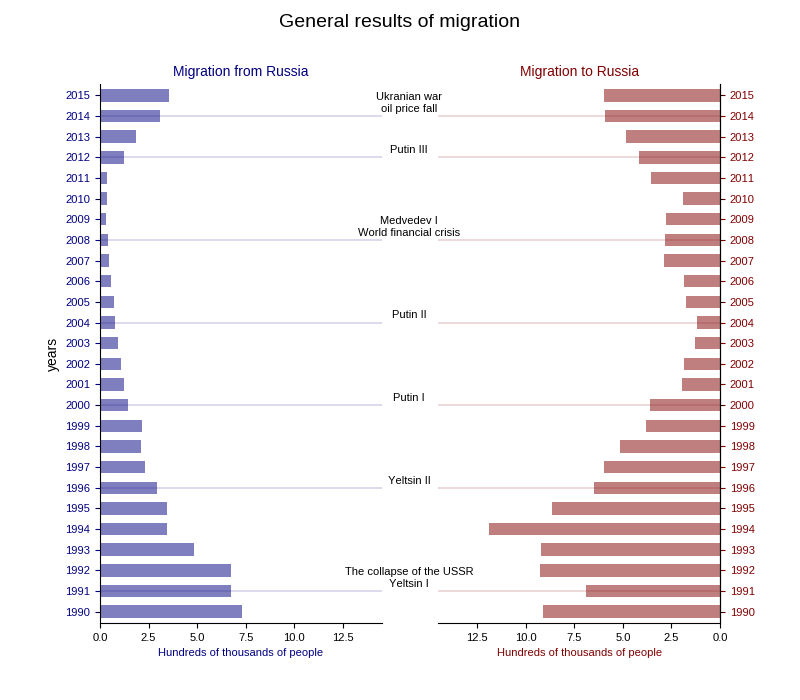

In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt

dfSum=read_sum_migration(strSumMigration).div(1e5)

iBaseYear=dfSum.index[0]

dKeyYears={2000:'Putin I', 2004:'Putin II', 2012:'Putin III', 2008:'Medvedev I\nWorld financial crisis', 2014:'Ukranian war\noil price fall', 
          1991:'The collapse of the USSR\nYeltsin I', 1996:'Yeltsin II'}

fig1, (axSumOut, axSumIn)=plt.subplots(1, 2, sharey=True, figsize=(8,7), facecolor='moccasin')
fig1.suptitle(strMainTitle, fontsize=iCaptionSize)
    

plot2bars(dfSum['MigrationOut'], dfSum['MigrationIn'], axSumOut, axSumIn, 
          bar_colors_in='maroon', bar_colors_out='navy', ano_lines=dKeyYears, strXLabel=strXlabel100)
    
plt.show();

In [11]:
#read migration by countries from source 

#mgr=read_sum_migration_country(strSumMigrationByCountry)
mgr=read_sum_migration_country(strSumMigrationByCountry, lstSplitRegion=lst_exUSSR_nr)
lstWorkCol=[i for i in mgr.columns.tolist() if str(i).isdigit()]

/home/egor/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


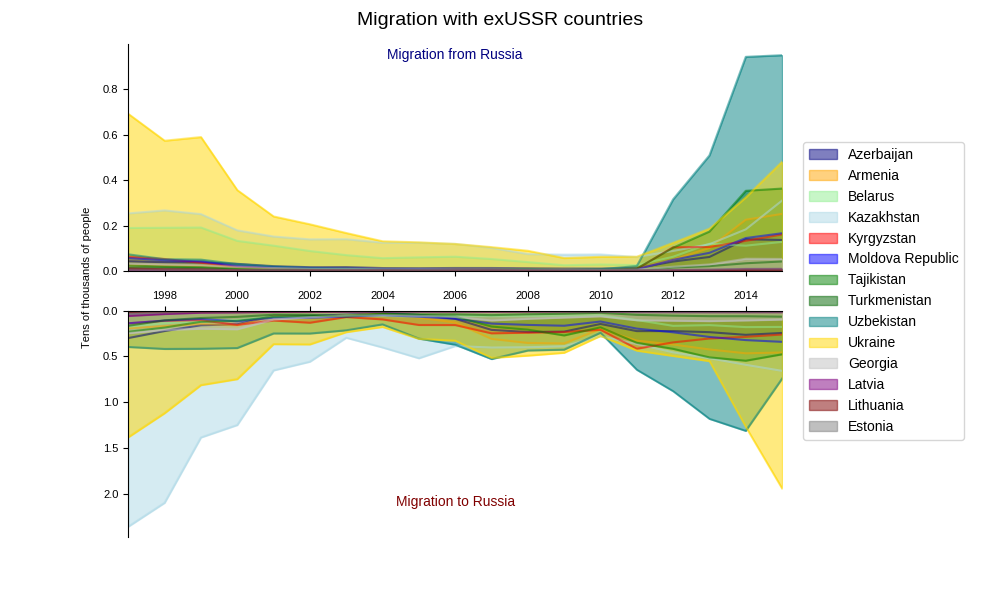

In [12]:
import matplotlib.gridspec as gSpc

#plt.style.use('seaborn-notebook')

cstrTitle4_exUSSR = 'Migration with exUSSR countries'

mOut_USSR=make_plot_dataframe(mgr, 'out', 'exUSSR', 10e4)
mIn_USSR=make_plot_dataframe(mgr, 'in', 'exUSSR', 10e4)

fig2=plt.figure(figsize=(10,6))
fig2.suptitle(cstrTitle4_exUSSR, fontsize=iCaptionSize)

gs=gSpc.GridSpec(2, 4, width_ratios=[0.2, 2.8, 2.8, 1.2]) #, height_ratios=[])

ax_t=fig2.add_subplot(gs[0, 0])
ax_t.text(0.5, 0.25, strXlabel10, rotation='vertical', fontsize=iTickLabelSize)
ax_t.axis('off')

ax_UOut=fig2.add_subplot(gs[0, 1:3])
ax_UIn=fig2.add_subplot(gs[1, 1:3], sharex=ax_UOut)
ax_USSR_legend=fig2.add_subplot(gs[0:, -1], sharex=None)

lst_colors1=['navy', 'orange', 'lightgreen', 'lightblue', 'red', 'blue', 'green', 
            'darkgreen', 'teal', 'gold', 'silver', 'purple', 'maroon', 'gray']

#mOut_USSR.T.plot.bar(stacked=True, alpha=0.7, color=lst_colors1, width=0.8, 
#                     ax=ax_UOut, legend=None, fontsize=8)
#mIn_USSR.T.plot.bar(stacked=True, alpha=0.7, color=lst_colors1, width=0.8, 
#                    ax=ax_UIn, legend=True, fontsize=8)

mOut_USSR.T.plot.area(stacked=False, alpha=fAplha, color=lst_colors1,
                     ax=ax_UOut, legend=None, fontsize=iTickLabelSize)
mIn_USSR.T.plot.area(stacked=False, alpha=fAplha, color=lst_colors1,
                    ax=ax_UIn, legend=True, fontsize=iTickLabelSize)


set_spines(ax_UIn, ['top', 'right'])
ax_UIn.invert_yaxis()

set_spines(ax_UOut, ['top', 'right'])

ax_UIn.spines['bottom'].set_position('zero')
ax_UIn.get_xaxis().set_tick_params(direction='out', labelsize=iTickLabelSize)
ax_UIn.get_xaxis().set_ticks_position('top')

ax_UOut.set_title(strOutTitle, fontsize=iAxisTitleSize, color=strColorOut, position=(0.5, 0.9))
ax_UIn.set_title(strInTitle, fontsize=iAxisTitleSize, color=strColorIn, position=(0.5, 0.1))
    
move_legend(ax_UIn, ax_USSR_legend)

fig2.tight_layout(pad=2.8, w_pad=0.01, h_pad=1)
plt.show();

<IPython.core.display.Javascript object>


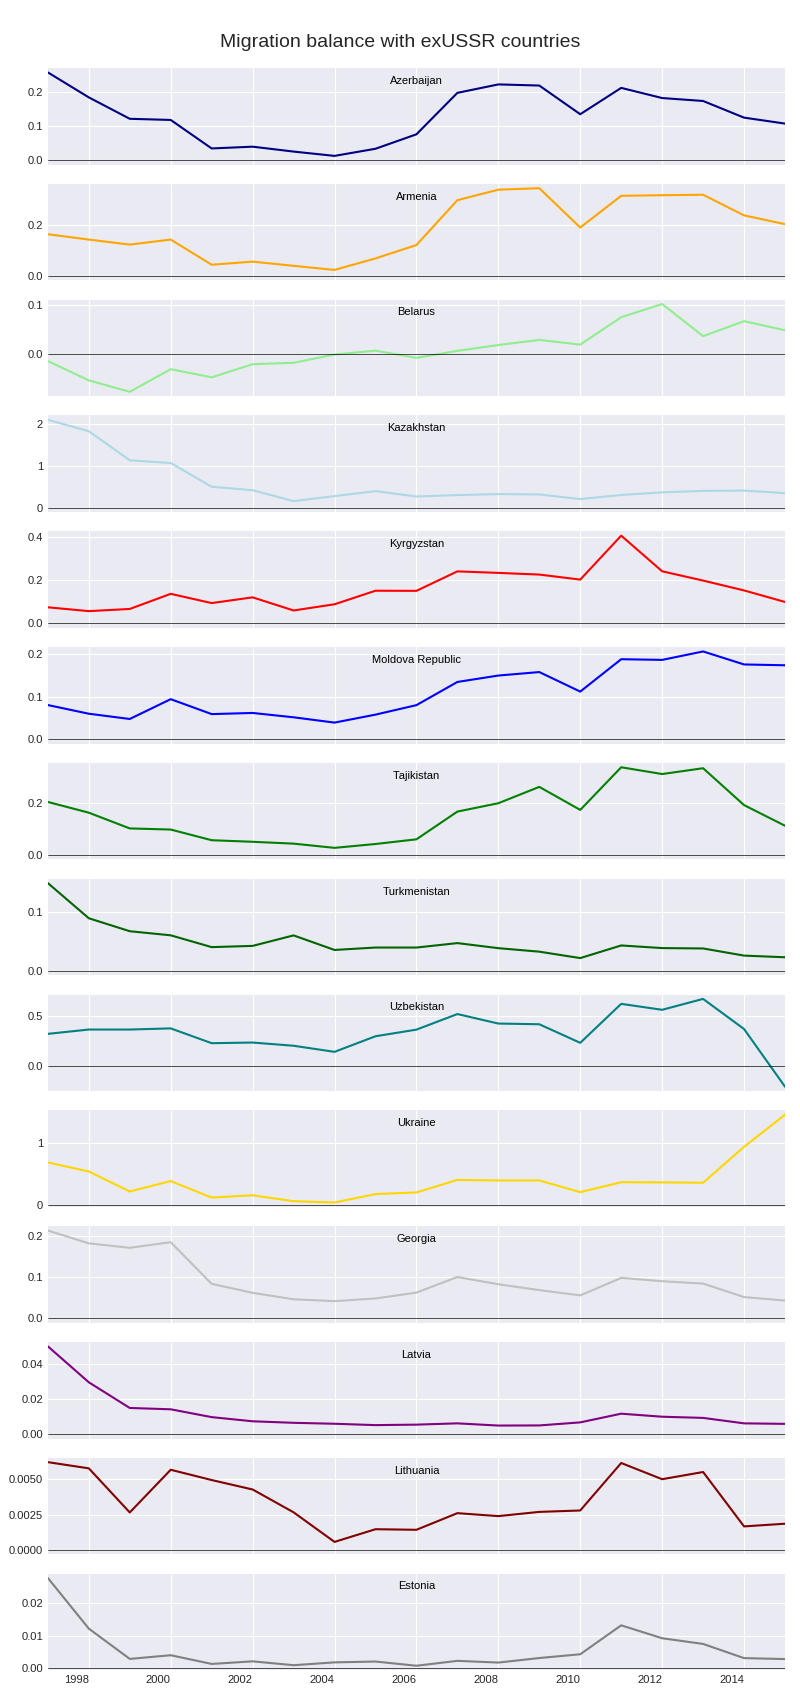

In [13]:
dv=mIn_USSR-mOut_USSR
#print(dv)
plt.style.use('seaborn-dark')
axSaldo=dv.T.plot(subplots=True, figsize=(8, 17), fontsize=8, color=lst_colors1, grid=True, rot=0)

for ax in axSaldo:
    hdl, lbl = ax.get_legend_handles_labels()
    ax.set_title(lbl[0], fontsize=8, color='black', position=(0.5, 0.75))
    ax.legend_.remove()
    ax.axhline(color='black', linestyle='-', linewidth=0.5, y=0)

axSaldo[0].get_figure().tight_layout()
axSaldo[0].get_figure().subplots_adjust(top=0.96)
axSaldo[0].get_figure().suptitle('Migration balance with exUSSR countries', fontsize=iCaptionSize);
#print(axSaldo)

In [14]:
mgrF=mgr

#mgrF.drop(mgrF.loc[['Abkhazia', 'South Osetia']].index, inplace=True)

m_F=mgrF[mgrF['AREA2']=='FOREIGN']

mOut_F=m_F[m_F['DIRECTION']=='out']
mIn_F=m_F[m_F['DIRECTION']=='in']

mOut_F=sum_and_sort(mOut_F, lstCols=lstWorkCol)
ddO=mOut_F[mOut_F['sum']>9500]
mIn_F=sum_and_sort(mIn_F, lstCols=lstWorkCol)
dd=mIn_F[mIn_F['sum']>9500]


/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:172: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/egor/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)


<IPython.core.display.Javascript object>


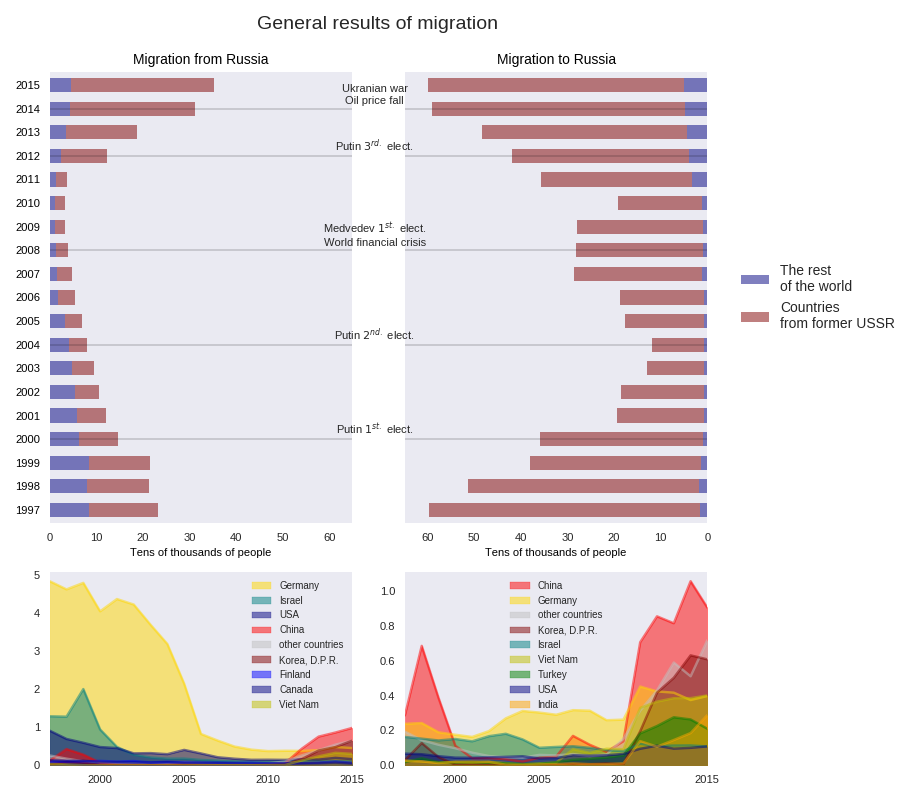

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:172: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/egor/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)


In [15]:
#import matplotlib.pyplot as plt
#import matplotlib.gridspec as gSpc

plt.style.use('seaborn-notebook')

    
#mgrPlot=read_sum_migration_country(strSumMigrationByCountry, lstSplitRegion=lst_exUSSR_nr)
mgrPlot=mgr
lstPlot= lstWorkCol + ['DIRECTION', 'AREA2']

iBaseYear=1997

dKeyYears={2000:'Putin $1^{st.}$ elect.', 2004:'Putin $2^{nd.}$ elect.', 2014:'Ukranian war\nOil price fall',
           2012:'Putin $3^{rd.}$ elect.', 2008:'Medvedev $1^{st.}$ elect.\nWorld financial crisis'}

strColorIn='black'
strColorOut='black'

#===============================================================


d=mgrPlot[lstPlot].groupby(['DIRECTION', 'AREA2']).sum()

dfOut=d.loc['out']
dfIn=d.loc['in']

dfOut=dfOut / fScale
dfIn=dfIn / fScale

fig1=plt.figure(figsize=(9,8))
ttl=fig1.suptitle(strMainTitle, fontsize=iCaptionSize)
ttl.set_position([0.42, 0.98])

gs=gSpc.GridSpec(2, 3, width_ratios=[4.2, 4.2, 1.6], height_ratios=[7, 3])

axSumOut=fig1.add_subplot(gs[0, 0])
axSumIn=fig1.add_subplot(gs[0, 1], sharey=axSumOut)

ax_legend=fig1.add_subplot(gs[0, 2], sharex=None)
ax_legend.axis('off')

axForIn=fig1.add_subplot(gs[1, 1])
axForOut=fig1.add_subplot(gs[1, 0])

ax_empt=fig1.add_subplot(gs[0, 2])
ax_empt.axis('off')

plot2bars(dfOut.T, dfIn.T, axSumOut, axSumIn, bar_colors_in=['navy', 'maroon'], 
              bar_colors_out=['navy', 'maroon'], ano_lines=dKeyYears, ano_lines_x=8.5, 
              stacked_bars=True, ax_legend=ax_legend, strXLabel=strXlabel10, 
              legend_labels=['The rest\nof the world', 'Countries\nfrom former USSR'])

#try:
   # m_F.drop(m_F.loc[['Abkhazia', 'South Osetia']].index, inplace=True)
#except:
#    pass

mOut_F=m_F[m_F['DIRECTION']=='out']
mIn_F=m_F[m_F['DIRECTION']=='in']

mOut_F=sum_and_sort(mOut_F, lstCols=lstWorkCol)
ddO=mOut_F[mOut_F['sum']>9500]
mIn_F=sum_and_sort(mIn_F, lstCols=lstWorkCol)
dd=mIn_F[mIn_F['sum']>9500]

dd=dd[lstWorkCol] / fScale
ddO=ddO[lstWorkCol] / fScale

axForIn=dd[lstWorkCol].T.plot.area(stacked=False, fontsize=8, 
                               color=['red', 'gold', 'silver', 'maroon', 'teal', 
                                      'y', 'green', 'navy', 'orange'], ax=axForIn)
axForIn.legend(title='', fontsize=7, loc=9)
set_spines(axForIn, ['top', 'right'])
axForOut=ddO[lstWorkCol].T.plot.area(stacked=False, fontsize=8, 
                               color=['gold', 'teal', 'navy', 'red', 'silver', 
                                      'maroon', 'blue', 'navy', 'y'], ax=axForOut)
axForOut.legend(title='', fontsize=7, loc=0)
set_spines(axForOut, ['top', 'right'])

fig1.tight_layout()

fig1.subplots_adjust(top=0.91)
plt.show();

In [16]:
pdCate=mgrPlot

lst_Categories=['Euro-Atlantic', 'Far East', 'Muslim', 'Caucas', 'RusWorld', 'other', 'Africa', 'South America']

lst_Islam=['Afghanistan', 'Algeria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Egypt', 'Indonesia', 
           'Iran', 'Iraq', 'Jordan', 'Kuwait', 'Kyrgyzstan', 'Lebanon', 'Libyan Arab Jamahiriya', 'Maldives', 
           'Mauritania', 'Morocco', 'Oman', 'Pakistan', 'Palestine', 'Qatar', 'Saudi Arabia', 'Somalia', 'Sudan', 
           'Syrian Arab Republic', 'Tajikistan', 'Tunisia', 'Turkey', 'Turkmenistan', 'Uzbekistan', 
           'Western Sahara', 'Yemen']

lst_Euro=['Albania', 'Andorra', 'Australia', 'Austria', 'Belgium', 'Bosnia & Herzegovina', 'Bulgaria', 'Canada', 'Cyprus',
          'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Gibraltar', 
          'Greece', 'Greenland', 'Guam', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Latvia', 'Liechtenstein', 
          'Lithuania', 'Luxembourg', 'Macedonia', 'Malta', 'Monaco', 'Montenegro', 'Netherlands', 
          'New Zealand', 'Norway', 'Poland', 'Portugal', 'Portugal', 'Romania', 'San Marino', 'Serbia', 
          'Slovakia', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'USA', 'United Kingdom']

lst_FarEast=['Bhutan', 'Cambodia', 'China', 'Hong Kong', 'India', 'Japan', 'Korea', 'Korea, D.P.R.', 
             'Lao P.D.R.', 'Malaysia', 'Nepal', 'Philippines', 'Singapore', 'Taiwan', 'Thailand', 'Viet Nam']

lst_Russ=['Moldova Republic', 'Belarus', 'Kazakhstan', 'Ukraine', 'Mongolia']

lst_Kavk=['Armenia', 'Abkhazia', 'Georgia', 'South Ossetia']

lst_Other=['other countries', 'v.c.', 'Other']

lst_Africa=['Angola', 'Botswana', 'Burundi', 'Cameroon', 'Chad', "Cote d'Ivoire", 
            'Democratic Republic of the Congo', 'Eritrea', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea', 
            'Guinea-Bissau', 'Kenya', 'Kiribati', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritius', 
            'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Republic of the Congo', 'Senegal', 'Togo', 
            'Uganda', 'Zambia', 'Zimbabwe']

lst_S_America=['Anguilla', 'Argentina', 'Aruba', 'Barbados', 'Belize', 'Benin', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 
               'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'Ecuador', 'Fiji', 'Grenada', 'Guadeloupe', 
               'Guatemala', 'Haiti', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Sri Lanka', 
               'Uruguay', 'Venezuela']

dct_cat={lst_Categories[2]:lst_Islam, lst_Categories[0]:lst_Euro, lst_Categories[1]:lst_FarEast, 
         lst_Categories[4]:lst_Russ, lst_Categories[5]:lst_Other+lst_Africa+lst_S_America, lst_Categories[3]:lst_Kavk}

pdCate.reset_index(inplace=True)
dct={}
for k, v in dct_cat.items():
    dct.update(dict.fromkeys(v, k))

pdCate['CULT']=pdCate['CountryEng'].map(dct)
pdCate['CULT']=pdCate['CULT'].astype('category', 
            categories=lst_Categories[:-2],  ordered=True)
pdCate.sort_values(by='CULT', inplace=True)

pdCate.set_index('CountryEng', inplace=True)
#print(pdCate)
#print()
#print (sorted(lst_S_America))

<IPython.core.display.Javascript object>


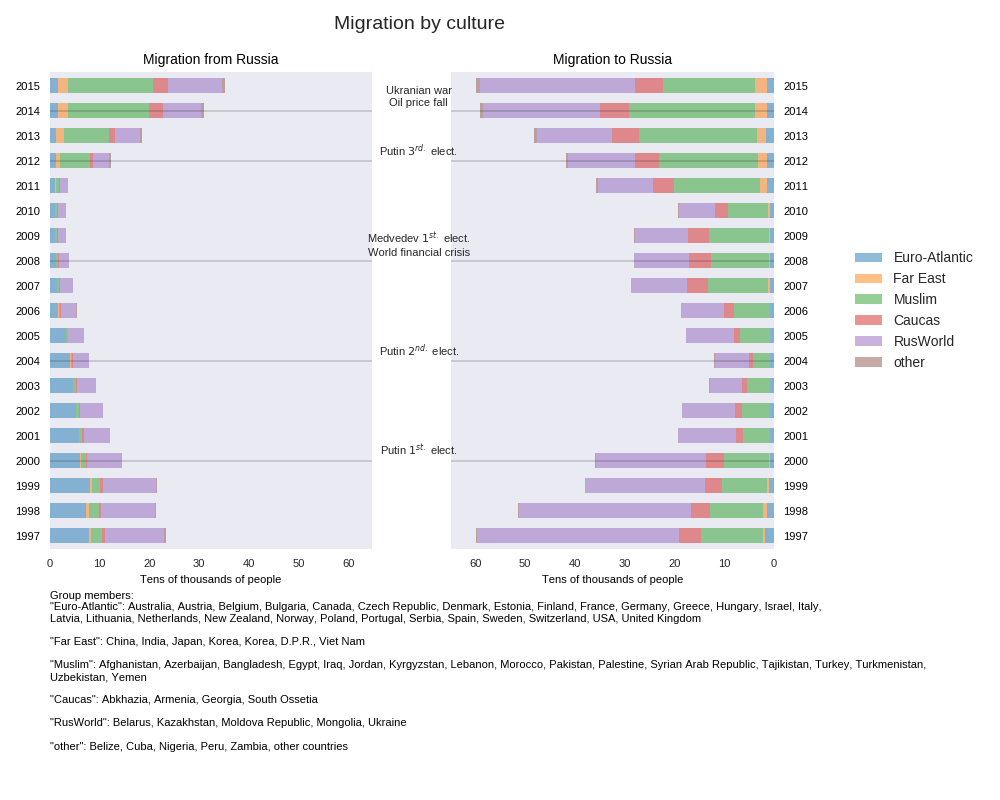

In [17]:
fScale=1e4
lstPlotCult= lstWorkCol + ['DIRECTION', 'CULT']

dCat=pdCate[lstPlotCult].groupby(['DIRECTION', 'CULT']).sum()

idx=pd.IndexSlice

dfOut_Cat=dCat.loc['out']
dfIn_Cat=dCat.loc['in']

dfOut_Cat=dfOut_Cat / fScale
dfIn_Cat=dfIn_Cat / fScale

#ploting ===============================
fig5=plt.figure(figsize=(10,8))
ttl=fig5.suptitle('Migration by culture', fontsize=iCaptionSize)
ttl.set_position([0.42, 0.98])

gsC=gSpc.GridSpec(2, 3, width_ratios=[4.2, 4.2, 1.6], height_ratios=[7.5, 2.5])

axCulOut=fig5.add_subplot(gsC[0, 0])
axCulIn=fig5.add_subplot(gsC[0, 1], sharey=axCulOut)

ax_clegend=fig5.add_subplot(gsC[0, 2], sharex=None)
ax_clegend.axis('off')

ax_text=fig5.add_subplot(gsC[1, :], sharex=None)
ax_text.axis('off')

plot2bars(dfOut_Cat.T,dfIn_Cat.T, axCulOut, axCulIn, ano_lines=dKeyYears, ano_lines_x=8.5, 
              stacked_bars=True, ax_legend=ax_clegend, strXLabel=strXlabel10)

print_text(ax_text, pdCate, step=14)

fig5.tight_layout()
fig5.subplots_adjust(top=0.91)
plt.show();


<IPython.core.display.Javascript object>


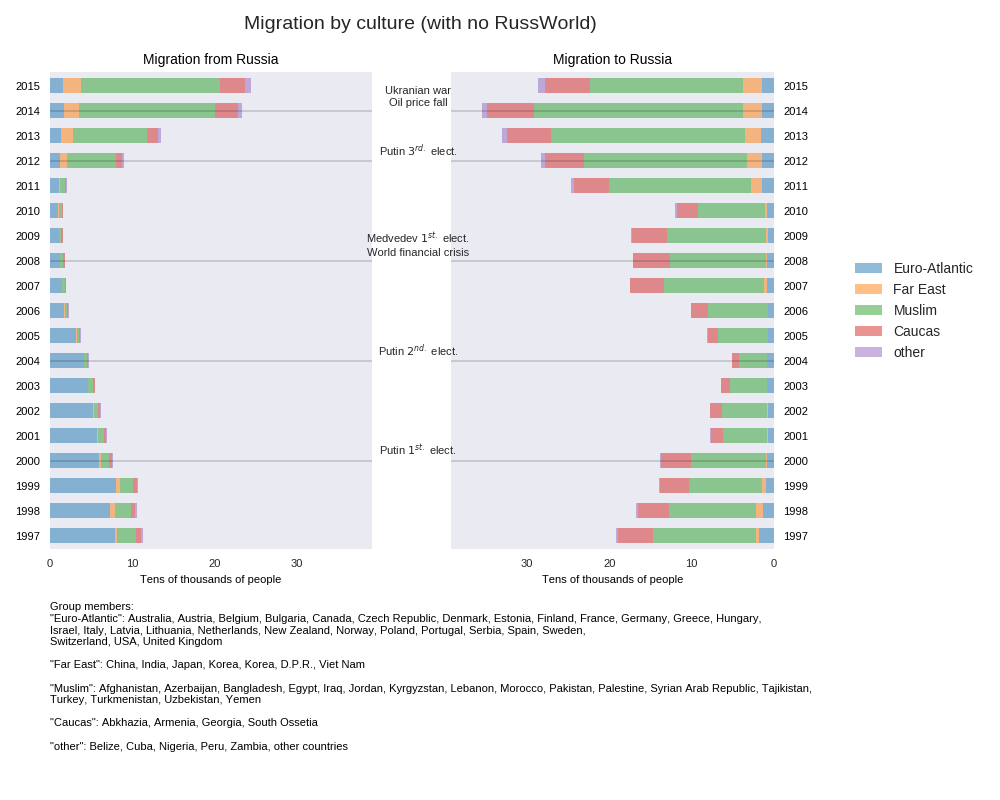

In [18]:
idx=pd.IndexSlice

dCatNR=dCat.loc[idx[:, [k for k in dct_cat.keys() if k != lst_Categories[4]]], idx[:]]
#print(dCatNR)

dfOut_CatNR=dCatNR.loc['out']
dfIn_CatNR=dCatNR.loc['in']
dfOut_CatNR=dfOut_CatNR / fScale
dfIn_CatNR=dfIn_CatNR / fScale

#ploting ===============================
fig6=plt.figure(figsize=(10, 8))
ttl=fig6.suptitle('Migration by culture (with no RussWorld)', fontsize=iCaptionSize)
ttl.set_position([0.42, 0.98])

gsCNR=gSpc.GridSpec(2, 3, width_ratios=[4.2, 4.2, 1.6], height_ratios=[7.5, 2.5])

axCulOutNR=fig6.add_subplot(gsCNR[0, 0])
axCulInNR=fig6.add_subplot(gsCNR[0, 1], sharey=axCulOut)

ax_clegendNR=fig6.add_subplot(gsCNR[0, 2], sharex=None)
ax_clegendNR.axis('off')
ax_textNR=fig6.add_subplot(gsCNR[1, :], sharex=None)
ax_textNR.axis('off')

plot2bars(dfOut_CatNR.T,dfIn_CatNR.T, axCulOutNR, axCulInNR, ano_lines=dKeyYears, ano_lines_x=6, 
              stacked_bars=True, ax_legend=ax_clegendNR, strXLabel=strXlabel10)

print_text(ax_textNR, pdCate[pdCate['CULT'].isin(set(dCatNR.index.get_level_values(1)))])

fig6.tight_layout()
fig6.subplots_adjust(top=0.91)
plt.show();

<IPython.core.display.Javascript object>


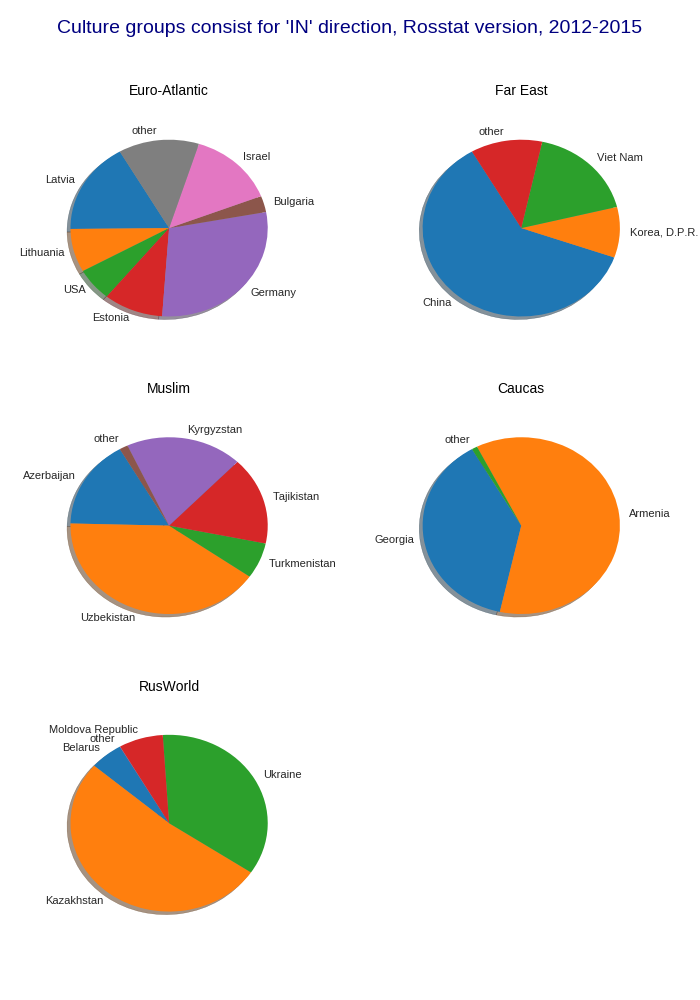

In [19]:
dfPie=pdCate.reset_index().set_index(['DIRECTION', 'CULT', 'CountryEng'])[lstWorkCol[:-4]]

#print(dfPie.loc[('in', 'RusWorld')].sum(axis=1))

i_cut_bins=12
str_direct='in'
#==== plotting ========

fig_p, ax_pies=plt.subplots(3, 2, figsize=(7, 10))
strCap="Culture groups consist for '{}' direction, Rosstat version, 2012-2015".format(str_direct.upper())

def plot_groups_consist(dtFrame, axes_list, str_title, i_bins, i_switch_off=1):
    lst_ax=[]

    for l_a in axes_list:
        for k in l_a:
            lst_ax.append(k)

    lst_ax[0].get_figure().suptitle(str_title, fontsize=iCaptionSize, color='navy')

    lst_culture=dtFrame.reset_index()['CULT'].unique()

    for i in range(len(lst_culture)-i_switch_off):
        p=dtFrame.loc[lst_culture[i]].sum(axis=1)
        s=pd.Series(pd.cut(p, i_cut_bins, right=True, 
                       include_lowest=True, labels=list(range(i_cut_bins)), retbins=True)[0])
        tmp=p[s==0].sum()
        p=p.drop(p[s==0].index)
        p['other']=tmp
        p.plot.pie(ax=lst_ax[i], fontsize=8, shadow=True, startangle=120, radius=0.8)
        lst_ax[i].set_title(lst_culture[i], fontsize=10, color='black', position=(0.5, 0.95))
        lst_ax[i].set_ylabel('')
    
    lst_ax[-1].axis('off')
    
plot_groups_consist(dfPie.loc[str_direct], ax_pies, strCap, i_cut_bins)
#lst_ax[-1].clear()
fig_p.tight_layout()
fig_p.subplots_adjust(top=0.91)
plt.show();

<IPython.core.display.Javascript object>


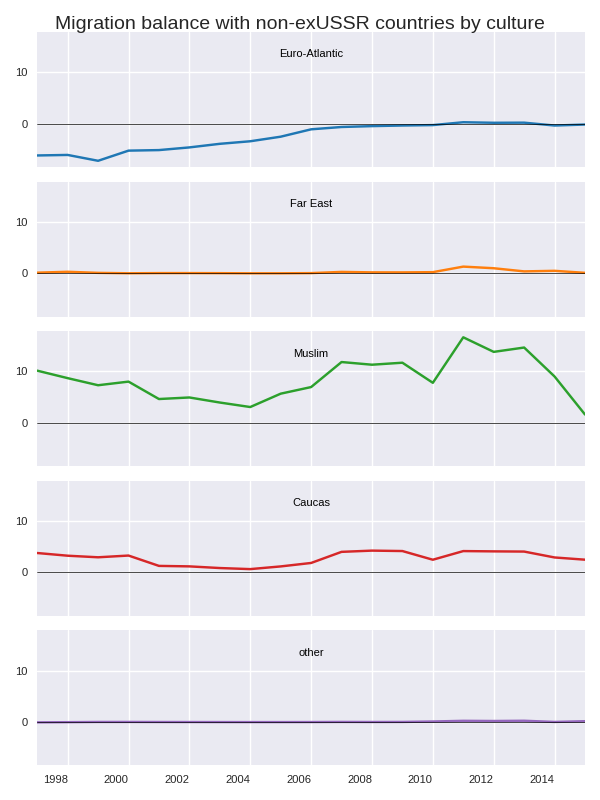

In [20]:
dBal=dfIn_CatNR-dfOut_CatNR

plt.style.use('seaborn-dark')
axSaldoCat=dBal.T.plot(subplots=True, figsize=(6, 8), fontsize=8, grid=True, rot=0, sharey=True)

for ax in axSaldoCat:
    hdl, lbl = ax.get_legend_handles_labels()
    ax.set_title(lbl[0], fontsize=8, color='black', position=(0.5, 0.75))
    ax.legend_.remove()
    ax.axhline(color='black', linestyle='-', linewidth=0.5, y=0)

axSaldoCat[0].get_figure().tight_layout()
axSaldoCat[0].get_figure().subplots_adjust(top=0.96)
axSaldoCat[0].get_figure().suptitle('Migration balance with non-exUSSR countries by culture', fontsize=iCaptionSize);

<IPython.core.display.Javascript object>


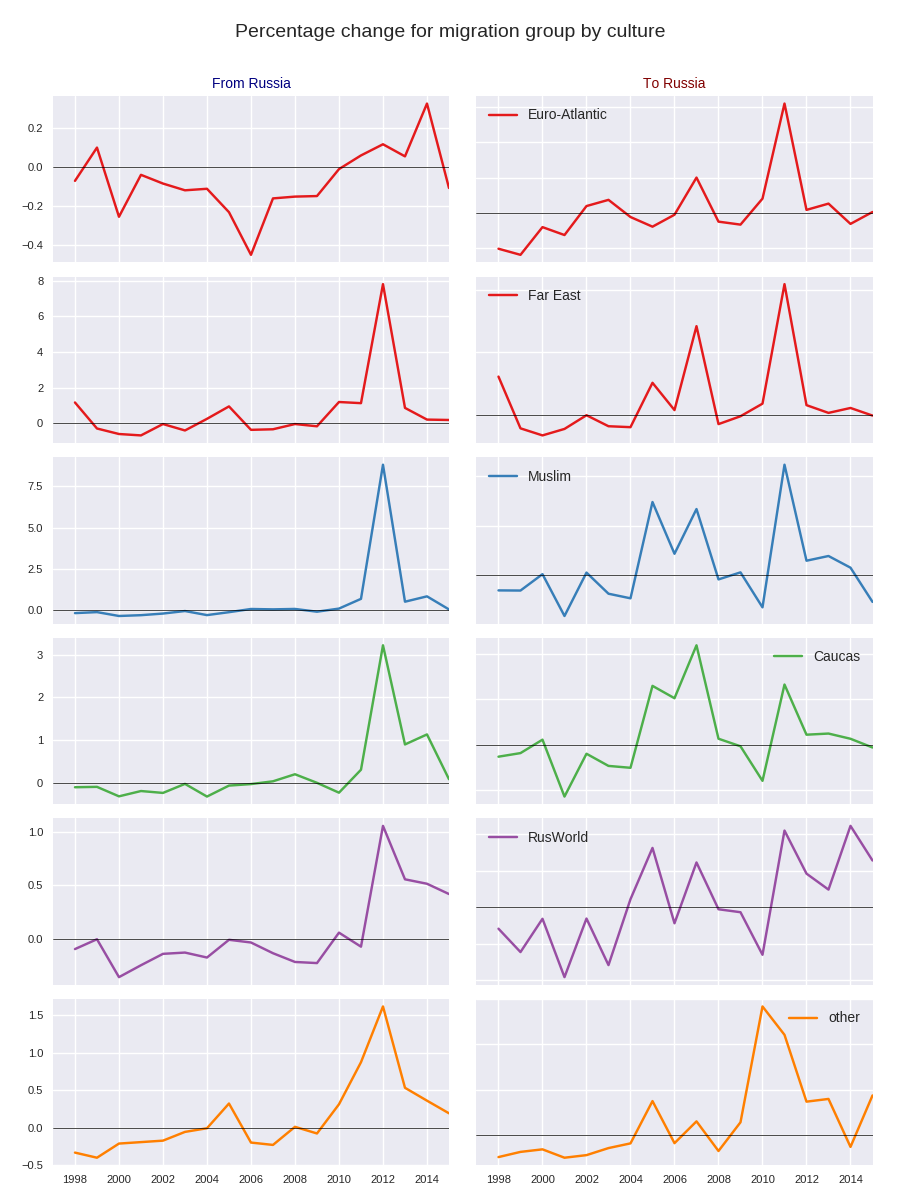

In [21]:
from matplotlib.pyplot import cm
#dfIn_CatNR-dfOut_CatNR

pct_In=dfIn_Cat.pct_change(axis=1)
pct_Out=dfOut_Cat.pct_change(axis=1)

fig8, ax_all = plt.subplots(len(pct_Out.index), 2, figsize=(9, 12))

cmap=cm.get_cmap('Set1')

for i in range(len(pct_Out.index)):
    ax_all[i][0]=pct_Out.iloc[i].plot.line(ax=ax_all[i][0], grid=True, color=cmap(0.1*i), 
                sharex=ax_all[0][0], sharey=ax_all[0][0], fontsize=8)
    ax_all[i][0].axhline(color='black', linestyle='-', linewidth=0.5, y=0)
    ax_all[i][1]=pct_In.iloc[i].plot.line(ax=ax_all[i][1], grid=True, legend=True, color=cmap(0.1*i),
                sharex=ax_all[0][0], sharey=ax_all[0][1], fontsize=8)
    ax_all[i][1].axhline(color='black', linestyle='-', linewidth=0.5, y=0)

ax_all[0][0].set_title('From Russia', fontsize=10, color='navy')
ax_all[0][1].set_title('To Russia', fontsize=10, color='maroon')
fig8.suptitle('Percentage change for migration group by culture', fontsize=iCaptionSize)
fig8.tight_layout()
fig8.subplots_adjust(top=0.92)
plt.show();

## Ministry of Internal Affairs of Russia
Statictics on visitors for 2016

<IPython.core.display.Javascript object>


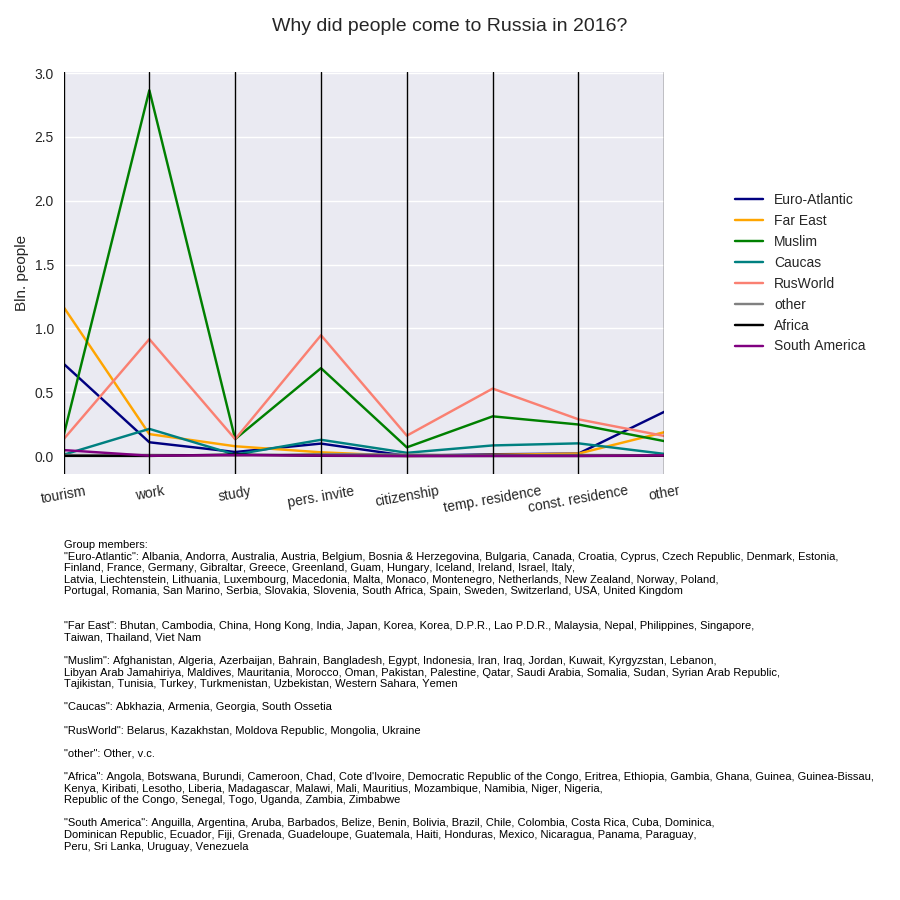

In [22]:
from matplotlib import cm
from pandas.tools.plotting import parallel_coordinates

mvd=read_mvd_data(strInternalViewByCountry)

dct_CAT={lst_Categories[2]:lst_Islam, lst_Categories[0]:lst_Euro, lst_Categories[1]:lst_FarEast, 
         lst_Categories[4]:lst_Russ, lst_Categories[5]:lst_Other, lst_Categories[6]:lst_Africa,
         lst_Categories[3]:lst_Kavk, lst_Categories[7]:lst_S_America}

mvd.reset_index(inplace=True)

mvd.drop(mvd[mvd['CountryEng'].isnull()].index, inplace=True)

dct_mvd={}
for k, v in dct_CAT.items():
    dct_mvd.update(dict.fromkeys(v, k))

mvd['CULT']=mvd['CountryEng'].map(dct_mvd)
mvd['CULT']=mvd['CULT'].astype('category', 
            categories=lst_Categories,  ordered=True)
mvd.sort_values(by='CULT', inplace=True)

mvd.set_index('CountryEng', inplace=True)

dMVDCat=mvd.groupby('CULT').sum()

lst_in_pict=['tourism', 'work', 'study', 'personal',
                                            'get_citi', 'rvp', 'pmg', 'other', 'des_rvp', 'des_pmg']

mvd_print_pc=dMVDCat[lst_in_pict]

mvd_print_pc=mvd_print_pc[lst_in_pict].div(1e6)

mvd_print_pc['rvp']=mvd_print_pc[['rvp', 'des_rvp']].sum(axis=1)
mvd_print_pc['pmg']=mvd_print_pc[['pmg', 'des_pmg']].sum(axis=1)
mvd_print_pc=mvd_print_pc.drop(['des_rvp', 'des_pmg'], axis=1)
mvd_print_pc.rename(index=str, columns={'personal':'pers. invite', 'rvp':'temp. residence',
                                        'get_citi':'citizenship', 'pmg':'const. residence'}, inplace=True)

#==== plotting ========

fig9=plt.figure(figsize=(9, 9))
plt.style.use('seaborn-colorblind')
#print(dMVDCat['tourism'])

prop=plt.rcParams['axes.prop_cycle']

#colors=[param['color'] for param in prop ]
colors=['navy', 'orange', 'green', 'teal', 'salmon', 'gray', 'black', 'purple']
c2=[cm.jet(0.1+i/10) for i in range(9) ]

#ttl=fig6.suptitle('Migration by culture (with no RussWorld)', fontsize=iCaptionSize)
#ttl.set_position([0.42, 0.98])

gsmvd=gSpc.GridSpec(2, 2, width_ratios=[8, 2], height_ratios=[5.5,4.5])

axParCoord=fig9.add_subplot(gsmvd[0, 0])
ax_mvd_leg=fig9.add_subplot(gsmvd[0, 1])
ax_mvd_leg.axis('off')

ax_mvd_text=fig9.add_subplot(gsmvd[1, :])
ax_mvd_text.axis('off')

axParCoord=parallel_coordinates(mvd_print_pc.reset_index(), 'CULT', color=colors, ax=axParCoord)

move_legend(axParCoord, ax_mvd_leg, lstLabels=None)

print_text(ax_mvd_text, mvd)

axParCoord.set_xticklabels(axParCoord.xaxis.get_majorticklabels(), rotation=10)
axParCoord.set_ylabel('Bln. people')

fig9.suptitle('Why did people come to Russia in 2016?', fontsize=iCaptionSize)
fig9.tight_layout()
fig9.subplots_adjust(top=0.92)

plt.show();

<IPython.core.display.Javascript object>


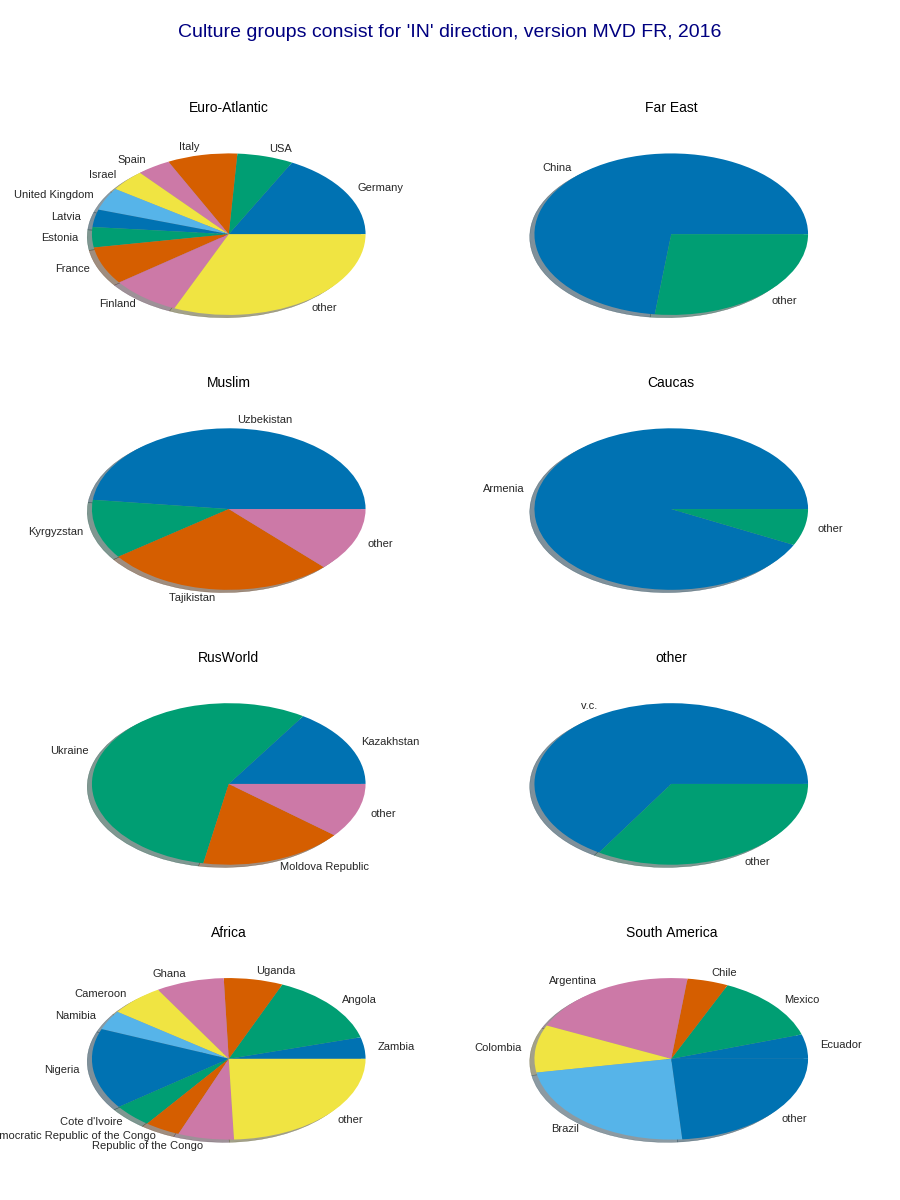

In [23]:
dfmvdPie=mvd.reset_index().set_index(['CULT', 'CountryEng'])['reg_all']

lst_cult=mvd['CULT'].dropna().unique()

i_cut_bins=5
str_direct='in'
#==== plotting ========

fig_p_mvd, ax_pies=plt.subplots(4, 2, figsize=(9, 12))
strCap="Culture groups consist for '{}' direction, version MVD FR, 2016".format(str_direct.upper())

def plot_groups_consist1(dtFrame, axes_list, str_title, i_bins, lst_cult, i_switch_off=1):
    lst_ax=[]

    for l_a in axes_list:
        for k in l_a:
            lst_ax.append(k)

    lst_ax[0].get_figure().suptitle(str_title, fontsize=iCaptionSize, color='navy')

    lst_culture=lst_cult

    for i in range(len(lst_culture)-i_switch_off):
        p=dtFrame.loc[lst_culture[i]]
        s=pd.Series(pd.cut(p, i_cut_bins, right=True, 
                       include_lowest=True, labels=list(range(i_cut_bins)), retbins=True)[0])
        tmp=p[s==0].sum()
        p=p.drop(p[s==0].index)
        p['other']=tmp
        p.plot.pie(ax=lst_ax[i], fontsize=8, shadow=True, startangle=0, radius=0.8)
        lst_ax[i].set_title(lst_culture[i], fontsize=10, color='black', position=(0.5, 0.95))
        lst_ax[i].set_ylabel('')
    
    lst_ax[-1].axis('off')
    
plot_groups_consist1(dfmvdPie, ax_pies, strCap, i_cut_bins, lst_cult, i_switch_off=0)
fig_p_mvd.tight_layout()
fig_p_mvd.subplots_adjust(top=0.91)
plt.show();